In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random


from queue import PriorityQueue
from sklearn.neighbors import NearestNeighbors
from numba import jit

%matplotlib inline

In [33]:
data_file = "./data/tsp_70_1"
data = pd.read_csv(data_file, sep=" ", names=["x", "y"], dtype={"x":float, "y":float})

In [34]:
data.head()

,x,y
0,70.0,NaN
1,67.0,99.0
2,48.0,83.0
3,75.0,81.0
4,8.0,19.0


In [35]:
n = int(data["x"][0])

In [36]:
class Vertex:
    
    def __init__(self, index, x, y):
        self.index = index
        self.x = x
        self.y = y

class Distance(object):

    def __init__(self, solution, distance):
        self.solution = solution
        self.distance = distance

    def __lt__(self, other):
        return self.distance < other.distance
    
class VertexDistance(object):

    def __init__(self, index, distance):
        self.index = index
        self.distance = distance
        
    def __lt__(self, other):
        return self.distance < other.distance


vertices = []
points = []
for i in range(1, n+1):
    vertices.append(Vertex(i-1, data["x"][i], data["y"][i]))
    points.append((data["x"][i], data["y"][i]))

In [37]:
def plotTSP(paths, points, num_iters=1):

    """
    path: List of lists with the different orders in which the nodes are visited
    points: coordinates for the different nodes
    num_iters: number of paths that are in the path list
    
    """

    # Unpack the primary TSP path and transform it into a list of ordered 
    # coordinates

    x = []; y = []
    for i in paths[0]:
        x.append(points[i][0])
        y.append(points[i][1])
    plt.plot(x, y, 'co')

    # Set a scale for the arrow heads (there should be a reasonable default for this, WTF?)
    a_scale = float(max(x))/float(100)

    # Draw the older paths, if provided
    if num_iters > 1:

        for i in range(1, num_iters):

            # Transform the old paths into a list of coordinates
            xi = []; yi = [];
            for j in paths[i]:
                xi.append(points[j][0])
                yi.append(points[j][1])

            plt.arrow(xi[-1], yi[-1], (xi[0] - xi[-1]), (yi[0] - yi[-1]), 
                    head_width = a_scale, color = 'r', 
                    length_includes_head = True, ls = 'dashed',
                    width = 0.001/float(num_iters))
            for i in range(0, len(x) - 1):
                plt.arrow(xi[i], yi[i], (xi[i+1] - xi[i]), (yi[i+1] - yi[i]),
                        head_width = a_scale, color = 'r', length_includes_head = True,
                        ls = 'dashed', width = 0.001/float(num_iters))

    # Draw the primary path for the TSP problem
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale, 
            color ='g', length_includes_head=True)
    for i in range(0,len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale,
                color = 'g', length_includes_head = True)

    #Set axis too slitghtly larger than the set of x and y
    plt.xlim(-1, max(x)*1.1)
    plt.ylim(-1, max(y)*1.1)
    plt.show()

In [112]:
@jit
def euclidean_distance(vertex_1, vertex_2):
    return np.sqrt( np.square(vertex_1.x - vertex_2.x)  + np.square(vertex_1.y - vertex_2.y) )

@jit
def objective_function(route):
    """
    Assume vertices is route starting and ending at same vertex e.g.
    [1, 3, 2, 0, 1]
    """
    head_route = route[0:(len(route)-1)]
    tail_route = route[1:]
    combined_route = zip(head_route, tail_route)
    dist_sum = 0.0
    for vertex_pair in combined_route:
        dist_sum += euclidean_distance(vertex_pair[0], vertex_pair[1])
    return dist_sum
  
@jit    
def is_valid_hamiltonian_cycle(route, n):
    # Ensure it starts and ends at same node
    start_and_end = route[0] == route[-1]
    
    # Need to ensure all vertices 0,..,n-1 are present
    all_index = list(range(0, n))
    indexes = sorted(list(set([vertex.index for vertex in route])))
    index_present = all_index == indexes
    
    return start_and_end and index_present

@jit
def tour_string(vertices):
    return " ".join([str(i.index) for i in vertices])

@jit
def tour_list(vertices):
    return [i.index for i in vertices]

# Improved NN approach
@jit
def nearest_neighbour_improved(vertices, n, points, max_search=0):
    nn_max = min(n, 500)
    remaining_indexes = set(range(0, n))
    starting_vertex = np.random.randint(0, n)
    remaining_indexes.remove(starting_vertex)
    tour = [vertices[starting_vertex]]
    used_index = set([starting_vertex])
    
    nbrs = NearestNeighbors(n_neighbors=nn_max, algorithm='auto').fit(points)
    distances, indices = nbrs.kneighbors(points)
    
    while len(remaining_indexes) > 0:
        cur_vertex = tour[-1]
        # Search nearest neighbours first
        nn_index = indices[cur_vertex.index]
        found_in_nearest = False
        for i in nn_index[1:]:
            if i not in used_index:
                # Found nearest, update the tour
                tour.append(vertices[i])
                remaining_indexes.remove(i)
                    
                used_index.add(i)
                found_in_nearest = True
                break
                
        if not found_in_nearest:
            solution_queue = PriorityQueue()

            num_checked = 0
            for i in remaining_indexes:
                dist = euclidean_distance(cur_vertex, vertices[i])
                solution_queue.put(VertexDistance(i, dist))
                num_checked += 1

                if (max_search != 0 and num_checked > max_search):
                    break

            # Select the shortest distance
            nearest = solution_queue.get()

            # Update the tour
            tour.append(vertices[nearest.index])
            remaining_indexes.remove(nearest.index)
            used_index.add(nearest.index)
            
    # Add final node to tour
    tour.append(tour[0])
        
    return tour
            
@jit
def nearest_neighbour(vertices, n, max_search=0):
    remaining_indexes = set(range(0, n))
    starting_vertex = np.random.randint(0, n)
    remaining_indexes.remove(starting_vertex)
    tour = [vertices[starting_vertex]]
    
    while len(remaining_indexes) > 0:
        cur_vertex = tour[-1]
        solution_queue = PriorityQueue()
        
        num_checked = 0
        for i in remaining_indexes:
            dist = euclidean_distance(cur_vertex, vertices[i])
            solution_queue.put(VertexDistance(i, dist))
            num_checked += 1
            
            if (max_search != 0 and num_checked > max_search):
                break
            
        # Select the shortest distance
        nearest = solution_queue.get()
        
        # Update the tour
        tour.append(vertices[nearest.index])
        remaining_indexes.remove(nearest.index)
        
    # Add final node to tour
    tour.append(tour[0])
        
    return tour

@jit
def two_opt_rand(vertices, n, points, route = None):
    
    route = nearest_neighbour_improved(vertices, n, points) if route == None else route
    cur_distance = objective_function(route)
    while True:
        # Randomely pick an edge
        i = np.random.randint(1, n)
       
        solution_queue = PriorityQueue()
        for j in range(i+1, len(route)):
            new_route = two_opt_swap(i, j, route, n)
            value = objective_function(new_route)
            solution_queue.put(Distance(new_route, value))
            
        best_move = solution_queue.get()
        best_distance = best_move.distance
        
        if (best_distance < cur_distance):
            cur_distance = best_distance
            route = best_move.solution
        else:
            break
            
    return route

@jit
def two_opt_rand_2(vertices, n, points, route):
    # Randomely pick an edge
    i = np.random.randint(1, n)
    j = np.random.randint(i+1, len(route))
    new_route = two_opt_swap(i, j, route, n)
    return new_route
    

@jit
def two_opt_swap(i, j, route, n):
    new_route = route[:]
    new_route[i:j] = route[j-1:i-1:-1] # this is the 2woptSwap
    assert(is_valid_hamiltonian_cycle(new_route, n))
    return new_route

@jit
def two_opt_full(vertices, n, points, seconds_timeout = 60):
        
    route = nearest_neighbour_improved(vertices, n, points)
    cur_distance = objective_function(route)
    start_time = round(time.time())
    
    while True:
        print(cur_distance)
        
        # Check timeout
        time_now = round(time.time())
        time_diff = time_now - start_time
        if (seconds_timeout != -1 and time_diff > seconds_timeout):
            print("TIMEOUT")
            break

        # Randomely pick an edge
        solution_queue = PriorityQueue()
        for i in range(1, n):
            # Check timeout
            time_now = round(time.time())
            time_diff = time_now - start_time
            if (seconds_timeout != -1 and time_diff > seconds_timeout):
                print("TIMEOUT")
                break
            
            for j in range(i+1, len(route)):
                new_route = two_opt_swap(i, j, route, n)
                value = objective_function(new_route)
                solution_queue.put(Distance(new_route, value))

        best_move = solution_queue.get()
        best_distance = best_move.distance

        if (best_distance < cur_distance):
            cur_distance = best_distance
            route = best_move.solution
        else:
            break
            
    return route

# 3 opt
# k-opt

In [115]:
@jit
def iterated_local_search(vertices, n, points, max_searches = 50):
    route = nearest_neighbour_improved(vertices, n, points)
    cur_distance = objective_function(route)
    
    for i in range(0, max_searches):
        route_proposed = two_opt_rand(vertices, n, points, route)
        distance_proposed =  objective_function(route_proposed)
        print(distance_proposed)
        
        if (distance_proposed < cur_distance):
            cur_distance = distance_proposed
            route = route_proposed
    
    return route

def metropolis_search(vertices, n, points):
    t = 5
    route = nearest_neighbour_improved(vertices, n, points)
    cur_distance = objective_function(route)
    
    for i in range(0, 100000):
    
        new_route = route#two_opt_rand_2(vertices, n, points, route)
        new_distance = objective_function(new_route)
        
        if new_distance < cur_distance:
            cur_distance = new_distance
            route = new_route
        # elif random.uniform(0, 1) <= np.exp(-(new_distance - cur_distance) / t):
        #     cur_distance = new_distance
        #    route = new_route
            
        if i % 1000 == 0:
            print(i)
    
    return route
    
    

In [116]:
a = metropolis_search(vertices, n, points)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


In [117]:
print(objective_function(a))

859.781579858


In [118]:
print(tour_list(a))

LoweringError: Failed at object (object mode backend)
make_function(name=$const0.2, code=<code object <listcomp> at 0x11814cc00, file "<ipython-input-112-27198ce0cef7>", line 37>, defaults=None, closure=None)
File "<ipython-input-112-27198ce0cef7>", line 37
[1] During: lowering "$0.3 = make_function(name=$const0.2, code=<code object <listcomp> at 0x11814cc00, file "<ipython-input-112-27198ce0cef7>", line 37>, defaults=None, closure=None)" at <ipython-input-112-27198ce0cef7> (37)

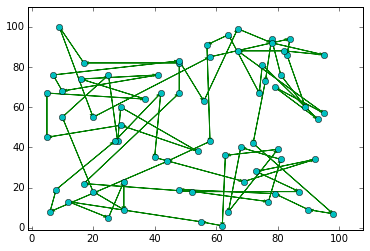

In [105]:
plotTSP([tour_list(a)[:-1]], points)

In [140]:
print(objective_function(a))

2746.32687084


In [71]:
points

[(0.0, 0.0), (0.0, 0.5), (0.0, 1.0), (1.0, 1.0), (1.0, 0.0)]

In [141]:
a[0:3]

[1, 2, 3]

In [157]:
max(0,2)

2

In [178]:
a[0:0]

[]

In [22]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='auto').fit(points)
distances, indices = nbrs.kneighbors(points)

In [27]:
indices[1]
distances[1]

array([  0.        ,   8.        ,   8.06225775,   8.24621125,
         8.60232527,   9.05538514,   9.21954446,  13.89244399,
        14.03566885,  15.        ,  16.03121954,  16.64331698,
        16.76305461,  18.97366596,  19.02629759,  19.84943324,
        19.84943324,  19.84943324,  20.22374842,  20.59126028])

In [24]:
distances

array([[  0.        ,   7.21110255,  10.04987562, ...,  29.42787794,
         30.01666204,  30.88689042],
       [  0.        ,   8.        ,   8.06225775, ...,  19.84943324,
         20.22374842,  20.59126028],
       [  0.        ,   6.32455532,   9.48683298, ...,  27.51363298,
         28.7923601 ,  29.73213749],
       ..., 
       [  0.        ,   6.08276253,   9.21954446, ...,  26.        ,
         26.57066051,  28.7923601 ],
       [  0.        ,   9.43398113,  10.77032961, ...,  29.        ,
         30.47950131,  30.59411708],
       [  0.        ,   6.40312424,  11.18033989, ...,  26.07680962,
         26.92582404,  29.68164416]])

In [60]:
n

150